Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1k4jn-czjTL_6pnQD96N3kA0uSq3cCGHcfNdKpfICURA/edit?usp=sharing).**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import Counter

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [2]:
RANDOM_STATE = 17

In [24]:
def visualize_tree_grid_results(tree_grid, return_median_score_dif = False):
    depths = [params['max_depth'] for params in tree_grid.cv_results_['params']]
    criterions = [params['criterion'] for params in tree_grid.cv_results_['params']]
    scores = np.array(tree_grid.cv_results_['mean_test_score'])

    separated_depths = {}
    separated_scores = {}
    for depth, criterion, score in zip(depths, criterions, scores):
        if criterion not in separated_depths:
            separated_depths[criterion] = list()
            separated_scores[criterion] = list()
        separated_depths[criterion].append(depth)
        separated_scores[criterion].append(score)
    for criterion in separated_depths:
        rearrange = np.argsort(separated_depths[criterion])
        separated_depths[criterion] = np.array(separated_depths[criterion])[rearrange]
        separated_scores[criterion] = np.array(separated_scores[criterion])[rearrange]

    for criterion in separated_depths:
        print(criterion, separated_scores[criterion])
        plt.plot(separated_depths[criterion], separated_scores[criterion])
    plt.legend(separated_depths.keys())
    plt.xlabel('depth')
    plt.ylabel('score')
    
    if return_median_score_dif:
        return np.max(np.abs(separated_scores['mad_median'] - separated_scores['classic_mad_median']))

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [4]:
from MyDecisionTree import DecisionTree

(13, 1)
(13,)
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    0.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'criterion': 'variance', 'max_depth': 6}
best score: -8.378284267173159
variance [-20.79676822 -19.49155366 -13.57130738  -8.44731983  -8.42951356
  -8.40714361  -8.37828427  -8.37828427  -8.37828427]
mad_median [-20.79676822 -18.22533018 -10.66577292  -8.42541812  -8.44623826
  -8.38408779  -8.37828427  -8.37828427  -8.37828427]
classic_mad_median [-20.79676822 -18.22533018  -8.96705498  -8.42541812  -8.44623826
  -8.38408779  -8.37828427  -8.37828427  -8.37828427]


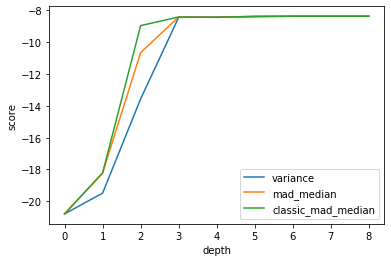

In [36]:
X = np.linspace(-2, 2, 13)
y = X ** 3
X = X.reshape(-1, 1)
print(X.shape)
print(y.shape)


tree_params = {'max_depth': list(range(0, 9)),
               'criterion': ['variance', 'mad_median', 'classic_mad_median']}

decisionTree = DecisionTree()
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'neg_mean_squared_error')
tree_grid.fit(X, y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

visualize_tree_grid_results(tree_grid)

In [62]:
worst_error = 0.0
worst_subset = None
for subset in [np.array([bool((num >> i) & 1) for i in range(len(X))]) for num in range(1, (1 << len(X)) - 1)]:
    train_X = X[subset]
    train_y = y[subset]
    test_X = X[~subset]
    decisionTree_1 = DecisionTree(max_depth = 2, criterion = 'mad_median')
    decisionTree_1.fit(train_X, train_y)
    predicted_1 = decisionTree_1.predict(X)
    decisionTree_2 = DecisionTree(max_depth = 2, criterion = 'classic_mad_median')
    decisionTree_2.fit(train_X, train_y)
    predicted_2 = decisionTree_2.predict(X)
    error = np.max(np.abs(predicted_1 - predicted_2))
    if error > worst_error:
        worst_error = error
        worst_subset = subset
        
print(worst_error)
print(worst_subset)

1.685185185185186
[ True  True False  True False False  True False False False False  True
  True]


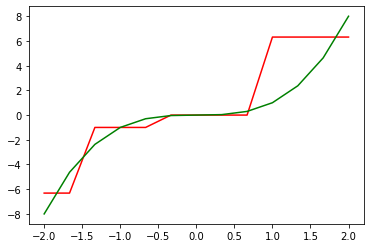

In [64]:
choose = [True, True, False, True, False, False, True, False, False, False, False, True, True]
train_X = X[choose]
train_y = y[choose]

decisionTree_1 = DecisionTree(max_depth = 2, criterion = 'mad_median')
decisionTree_1.fit(train_X, train_y)
predicted_1 = decisionTree_1.predict(X)
plt.plot(X, predicted_1, 'r', X, y, 'g')

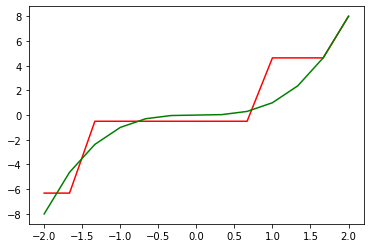

In [65]:
decisionTree_2 = DecisionTree(max_depth = 2, criterion = 'classic_mad_median')
decisionTree_2.fit(train_X, train_y)
predicted_2 = decisionTree_2.predict(X)
plt.plot(X, predicted_2, 'r', X, y, 'g')

In [66]:
print(np.max(np.abs(predicted_1 - predicted_2)))

1.685185185185186


## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [6]:
X, y = load_digits(return_X_y = True)
X = np.array(X)
y = np.array(y)
print(X, X.shape)
print(y, y.shape)
print()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 17)
print(train_X, train_X.shape)
print(test_X, test_X.shape)
print()
print(train_y, train_y.shape)
print(test_y, test_y.shape)
print()

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] (1797, 64)
[0 1 2 ... 8 9 8] (1797,)

[[ 0.  0.  3. ... 16.  2.  0.]
 [ 0.  0.  6. ...  0.  0.  0.]
 [ 0.  1.  7. ...  0.  0.  0.]
 ...
 [ 0.  6. 16. ... 11.  1.  0.]
 [ 0.  1.  8. ...  0.  0.  0.]
 [ 0.  0.  0. ... 16. 16. 16.]] (1437, 64)
[[ 0.  0.  0. ...  6.  0.  0.]
 [ 0.  0.  0. ... 14.  4.  0.]
 [ 0.  0.  5. ...  0.  0.  0.]
 ...
 [ 0.  0.  2. ... 15.  4.  0.]
 [ 0.  0.  4. ...  6.  0.  0.]
 [ 0.  0. 13. ...  0.  0.  0.]] (360, 64)

[1 9 5 ... 3 7 1] (1437,)
[1 2 7 3 9 5 8 9 8 1 4 3 5 0 9 9 5 3 9 6 6 3 6 4 6 2 6 7 3 1 8 4 1 1 0 2 3
 5 5 5 5 6 0 5 3 5 1 8 2 9 9 4 0 8 8 1 1 1 0 4 1 2 0 7 9 8 8 6 0 8 8 3 4 6
 4 3 2 3 9 7 5 8 3 5 1 8 9 5 4 7 7 8 3 0 2 7 9 9 4 0 5 6 4 0 1 3 3 1 8 7 4
 2 5 5 3 9 6 4 2 7 4 1 8 5 1 5 8 6 5 5 4 9 4 2 7 8 4 4 4 9 7 1 9 9 2 0 0 3
 5 8 1 9 5 3 6 8 7 4 6 1 9 7 6 4 0 9 4

In [7]:
import time

start = time.time()
decisionTree = DecisionTree(max_depth = 11, criterion = 'entropy')
decisionTree.fit(train_X, train_y)
end = time.time()
print(end - start)

start = time.time()
decisionTree.predict(test_X)
end = time.time()
print(end - start)

start = time.time()
decisionTree.predict_proba(test_X)
end = time.time()
print(end - start)

5.947190284729004
0.0049855709075927734
0.006981372833251953


С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best parameters: {'criterion': 'entropy', 'max_depth': 8}
best score: 0.8698677800974252
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   56.9s finished


best parameters: {'criterion': 'entropy', 'max_depth': 8}
best score: 0.8636047320807237
gini [0.46764092 0.57689631 0.68128045 0.76130828 0.8197634  0.82950592
 0.84272791 0.83855254]
entropy [0.52331246 0.67571329 0.76270007 0.81837161 0.84899095 0.86360473
 0.86360473 0.86082116]


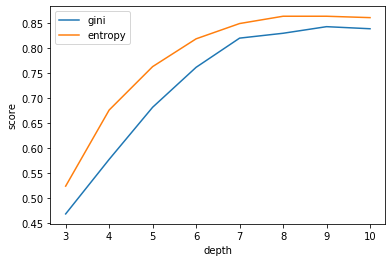

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree_params = {'max_depth': list(range(3, 11)), 'criterion': ['gini', 'entropy']}

decisionTree = DecisionTreeClassifier()
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'accuracy')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))


tree_params = {'max_depth': list(range(3, 11)),
               'criterion': ['gini', 'entropy']}

decisionTree = DecisionTree()
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'accuracy')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

visualize_tree_grid_results(tree_grid)

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9]. +
2. На отрезке [3, 10] построенные графики не пересекаются. +
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз. -
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`. -
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10]. -?

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy'; <---
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [9]:
decisionTree = DecisionTree(max_depth = 9, criterion = 'entropy')
decisionTree.fit(train_X, train_y)
predicted = decisionTree.predict_proba(test_X)
print(predicted, predicted.shape)
print()

predicted = np.mean(predicted, axis = 0)
print(predicted, predicted.shape)
print(np.max(predicted))

[[0.         0.95652174 0.         ... 0.         0.04347826 0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]] (360, 10)

[0.09166667 0.06986715 0.10648148 0.08981481 0.125      0.12083333
 0.07777778 0.09398148 0.11022544 0.11435185] (10,)
0.125


Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127 <---
2. 0.118
3. 1.0
4. 0.09

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [10]:
X, y = load_boston(return_X_y = True)
X = np.array(X)
y = np.array(y)
print(X, X.shape)
print(y, y.shape)
print()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 17)
print(train_X, train_X.shape)
print(test_X, test_X.shape)
print()
print(train_y, train_y.shape)
print(test_y, test_y.shape)
print()

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]] (506, 13)
[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best parameters: {'criterion': 'mse', 'max_depth': 5}
best score: -21.84154407057814
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Done  98 out of 105 | elapsed:   32.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   39.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'criterion': 'mad_median', 'max_depth': 4}
best score: -20.48134600596055
variance [-32.54446912 -27.4885989  -22.30902741 -21.67349513 -21.93564757
 -22.22576576 -22.60023282]
mad_median [-32.5360341  -23.71135689 -20.48134601 -24.49422393 -24.33574287
 -23.67182034 -24.9076434 ]
classic_mad_median [-32.5360341  -26.93978409 -22.85922843 -27.58383269 -27.18750552
 -26.56884706 -27.37965484]


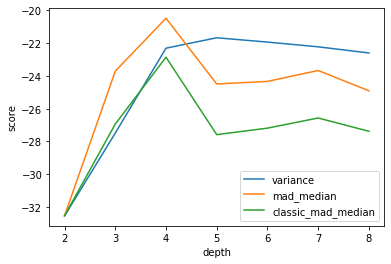

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_params = {'max_depth': list(range(2, 9)), 'criterion': ['mse', 'mae']}

decisionTree = DecisionTreeRegressor()
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'neg_mean_squared_error')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))


tree_params = {'max_depth': list(range(2, 9)),
               'criterion': ['variance', 'mad_median', 'classic_mad_median']}

decisionTree = DecisionTree()
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'neg_mean_squared_error')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

visualize_tree_grid_results(tree_grid)

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются. -
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз. +?
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8]. -
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`. +

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median'; <---
6. max_depth = 5, criterion = 'variance';

In [12]:
decisionTree = DecisionTree(max_depth = 7, criterion = 'classic_mad_median')
decisionTree.fit(train_X, train_y)
print('{0:e}'.format(decisionTree.median_dif_))

2.042810e-14


In [13]:
print(y)

[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.4 19.8 19.4 21.7 22.8
 18.8 18.7 18.5 18.3 21.2 19.2 20.4 19.3 22.  20.3 20.5 17.3 18.8 21.4
 15.7 16.2 18.  14.3 19.2 19.6 23.  18.4 15.6 18.1 17.4 17.1 13.3 17.8
 14.  14.4 13.4 15.6 11.8 13.8 15.6 14.6 17.8 15.4 21.5 19.6 15.3 19.4
 17.  15.6 13.1 41.3 24.3 23.3 27.  50.  50.  50.  22.7 25.  50.  23.8
 23.8 22.3 17.4 19.1 23.1 23.6 22.6 29.4 23.2 24.6 29.9 37.2 39.8 36.2
 37.9 32.5 26.4 29.6 50.  32.  29.8 34.9 37.  30.5 36.4 31.1 29.1 50.
 33.3 3